In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dhai-ecg-dataset/ecg_processed_data_2.csv


In [3]:
import os
import itertools
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
%matplotlib inline

In [5]:
ecg_path = "/kaggle/input/dhai-ecg-dataset/ecg_processed_data_2.csv"

In [6]:
ecg_data = pd.read_csv(ecg_path, index_col=0)

In [7]:
ecg_data.head()

,Segment Start,Segment End,xs0,xs1,xs2,xs3,xs4,xs5,xs6,xs7,...,xs193,xs194,xs195,xs196,xs197,xs198,xs199,Annotation Class,Annotation Class Numeric,acn
Record ID,,,,,,,,,,,,,,,,,,,,,
100,13,213,0.059449,0.055308,0.052035,0.049666,0.047961,0.046922,0.046801,0.047770,...,0.033233,0.033981,0.034276,0.034166,0.033702,0.033134,0.032648,N,1,0
100,307,507,0.084239,0.087566,0.088956,0.088621,0.086919,0.084459,0.081823,0.079506,...,0.020049,0.020272,0.020719,0.020971,0.020866,0.020622,0.020434,N,1,0
100,563,763,-0.006937,-0.005690,-0.005184,-0.005172,-0.005405,-0.005802,-0.006385,-0.007163,...,-0.084798,-0.084841,-0.084325,-0.082953,-0.080644,-0.077424,-0.073181,N,1,0
100,883,1083,0.072086,0.073128,0.073026,0.071802,0.069731,0.067336,0.065156,0.063624,...,0.040605,0.040177,0.039328,0.038051,0.036671,0.035565,0.034817,N,1,0
100,1168,1368,0.084762,0.083995,0.082327,0.080127,0.077701,0.075216,0.072963,0.071264,...,0.025977,0.027249,0.029211,0.031715,0.034364,0.036462,0.037443,N,1,0


In [8]:
ecg_data["Annotation Class"].unique()

array(['N', 'V', '/', 'L', 'R'], dtype=object)

In [9]:
id_to_label = {val: idx for idx, val in enumerate(list(ecg_data["Annotation Class"].unique()))}

In [10]:
x_columns = [f"xs{i}" for i in range(0, 200)]

In [11]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    attn_state_path = '/kaggle/working/attn.pth'
    lstm_state_path = '/kaggle/working/lstm.pth'
    cnn_state_path = '/kaggle/working/cnn.pth'
    
    attn_logs = '/kaggle/working/attn.csv'
    lstm_logs = '/kaggle/working/lstm.csv'
    cnn_logs = '/kaggle/working/cnn.csv'
    
    ecg_csv_path = '/kaggle/input/dhai-ecg-dataset/ecg_processed_data_2.csv'

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
config = Config()
seed_everything(config.seed)

In [12]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.X = torch.tensor(self.df.iloc[:,3:-3].values, dtype=torch.float32)
        self.y = torch.tensor(self.df.iloc[:,-1].values, dtype=torch.long) 

    def __getitem__(self, idx):
        signal = torch.reshape(self.X[idx],(1,200))
        target = self.y[idx]
        return signal, target

    def __len__(self):
        return len(self.df)

In [13]:
def get_dataloader(train_csv_path: str, phase: str, batch_size: int = 96) -> DataLoader:
    '''
    Dataset and DataLoader.
    Parameters:
        train_csv_path: processed_data path.
        phase: training, testing or validation phase.
        target: Annotation Class Numeric
        signal_cols: columns belonging to signal
        batch_size: data per iteration.
    Returns:
        data generator
    '''
    df = pd.read_csv(train_csv_path)
   
    t_df, test_df = train_test_split( df, test_size=0.2, random_state=42, stratify=df['acn'])
    
    t_df, test_df = t_df.reset_index(drop=True), test_df.reset_index(drop=True)
    
    train_df, val_df = train_test_split(t_df, test_size=0.25, random_state=42, stratify=t_df['acn'])

    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

    if phase == 'train':
        df = train_df
    elif phase == 'val':
        df = val_df
    else:
        df = test_df

    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size)
    
    return dataloader

In [14]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))

    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x, y)
        self.metrics['f1'] += f1_score(x, y, average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x, y, average='macro', zero_division=1)

        self._compute_cm(x, y)

    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1

    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0

    def get_metrics(self):
        return self.metrics

    def get_confusion_matrix(self):
        return self.confusion


class Trainer:
    def __init__(self, train_csv_path, net, lr, batch_size, num_epochs, model_nm):
        self.net = net.to(config.device)
        self.num_epochs = num_epochs
        self.model_nm = model_nm
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = AdamW(self.net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(train_csv_path, phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()

    def _train_epoch(self, phase):
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == 'train' else self.net.eval()
        meter = Meter()
        meter.init_metrics()
        

        for i, (data, target) in enumerate(self.dataloaders[phase]):
            data = data.to(config.device)
            target = target.to(config.device)

            output = self.net(data)
            loss = self.criterion(output, target)
            if phase == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            meter.update(output, target, loss.item())
            
        metrics = meter.get_metrics()
        metrics = {k: v / i for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])
        confusion_matrix = meter.get_confusion_matrix()
        print("completed metrics calc")
        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)

        # show logs
        print('{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'
              .format(*(x for kv in metrics.items() for x in kv))
              )
        fig, ax = plt.subplots(figsize=(5, 5))
        cm_ = ax.imshow(confusion_matrix, cmap='hot')
        ax.set_title('Confusion matrix', fontsize=15)
        ax.set_xlabel('Actual', fontsize=13)
        ax.set_ylabel('Predicted', fontsize=13)
        plt.colorbar(cm_)
        plt.show()

        return loss

    def run(self):
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train')
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val')
                self.scheduler.step()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\nNew checkpoint\n')
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), f"best_model_epoc{epoch}.pth")
            if epoch == (self.num_epochs - 1):
                torch.save(self.net.state_dict(), f"{self.model_nm}.pth")
            # clear_output()


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ConvNormPool(nn.Module):
    """Conv Skip-connection module"""

    def __init__(
            self,
            input_size,
            hidden_size,
            kernel_size,
            norm_type='bachnorm'
    ):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)

        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1 + conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.pool(x)
        return x

class CNN(nn.Module):
    def __init__(
            self,
            input_size=1,
            hid_size=256,
            kernel_size=5,
            num_classes=5,
    ):
        super().__init__()

        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size // 2,
            kernel_size=kernel_size,
        )
        self.conv3 = ConvNormPool(
            input_size=hid_size // 2,
            hidden_size=hid_size // 4,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size // 4, out_features=num_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        # print(x.shape) # num_features * num_channels
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1)
        return x

class RNN(nn.Module):
    """RNN module(cell type lstm or gru)"""

    def __init__(
            self,
            input_size,
            hid_size,
            num_rnn_layers=1,
            dropout_p=0.2,
            bidirectional=False,
            rnn_type='lstm',
    ):
        super().__init__()

        if rnn_type == 'lstm':
            self.rnn_layer = nn.LSTM(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )

        else:
            self.rnn_layer = nn.GRU(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )

    def forward(self, input):
        outputs, hidden_states = self.rnn_layer(input)
        return outputs, hidden_states

class RNNModel(nn.Module):
    def __init__(
            self,
            input_size,
            hid_size,
            rnn_type,
            bidirectional,
            n_classes=5,
            kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=50  ,  # hid_size * 2 if bidirectional else hid_size,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x, _ = self.rnn_layer(x)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1  )  # .squeeze(1)
        return x


class RNNAttentionModel(nn.Module):
    def __init__(
            self,
            input_size,
            hid_size,
            rnn_type,
            bidirectional,
            n_classes=5,
            kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=50,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveMaxPool1d((1))
        self.attn = nn.Linear(hid_size, hid_size, bias=False)
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x_out, hid_states = self.rnn_layer(x)
        x = torch.cat([hid_states[0], hid_states[1]], dim=0).transpose(0, 1)
        x_attn = torch.tanh(self.attn(x))
        x = x_attn.bmm(x_out)
        x = x.transpose(2, 1)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=-1)
        return x

In [16]:
m1 = CNN(num_classes=5, hid_size=128)
m2 = RNNAttentionModel(1, 64, 'lstm', False)
m3 = RNNModel(1, 64, 'lstm', True)

In [17]:
model_dict = {'cnn':m1, 'attn':m2, 'lstm': m3}

In [18]:
def n_model_logs_aggregator(model, model_nm):
    
    ##training
    trainer = Trainer(train_csv_path=ecg_path,net=model, lr=1e-3, batch_size=96, num_epochs=10, model_nm=model_nm)#100)
    trainer.run()
    
    ##logging
    train_logs = trainer.train_df_logs
    train_logs.columns = ["train_"+ colname for colname in train_logs.columns]
    val_logs = trainer.val_df_logs
    val_logs.columns = ["val_"+ colname for colname in val_logs.columns]

    logs = pd.concat([train_logs,val_logs], axis=1)
    logs.reset_index(drop=True, inplace=True)
    logs = logs.loc[:, [
        'train_loss', 'val_loss', 
        'train_accuracy', 'val_accuracy', 
        'train_f1', 'val_f1',
        'train_precision', 'val_precision',
        'train_recall', 'val_recall']
                                     ]
    logs.head()
    logs.to_csv(f"{model_nm}.csv", index=False)
    
    model = model.to(config.device)
    model.load_state_dict(torch.load(f"/kaggle/working/{model_nm}.pth",map_location=config.device));
    model.eval();
    logs = pd.read_csv(f"{model_nm}.csv",)
    
    colors = ['#C042FF', '#03C576FF', '#FF355A', '#03C5BF', '#96C503', '#C5035B']
    palettes = [sns.color_palette(colors, 2),
                sns.color_palette(colors, 4), 
                sns.color_palette(colors[:2]+colors[-2:] + colors[2:-2], 6)]
            
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.lineplot(data=logs.iloc[:, :2], palette=palettes[0], markers=True, ax=ax[0], linewidth=2.5,)
    ax[0].set_title("Loss Function during Model Training", fontsize=14)
    ax[0].set_xlabel("Epoch", fontsize=14)

    sns.lineplot(data=logs.iloc[:, 2:6], palette=palettes[1], markers=True, ax=ax[1], linewidth=2.5, legend="full")
    ax[1].set_title("Metrics during Model Training", fontsize=15)
    ax[1].set_xlabel("Epoch", fontsize=14)

    plt.suptitle(f"{model_nm}", fontsize=18)

    plt.tight_layout()
    fig.savefig(f"{model_nm}.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
    fig.savefig(f"{model_nm}.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

train mode | time: 15:34:49
completed metrics calc
loss: 1.0058368552289603, accuracy: 0.9528136779752282, f1: 0.893742578568206, precision: 0.9058799870801628, recall: 0.9278837022913725


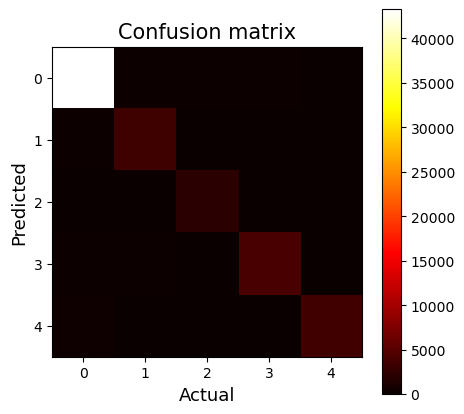

val mode | time: 15:38:26
completed metrics calc
loss: 0.9265944766766817, accuracy: 0.9941343042071208, f1: 0.9831574091401954, precision: 0.9835541720787115, recall: 0.9877718444904294


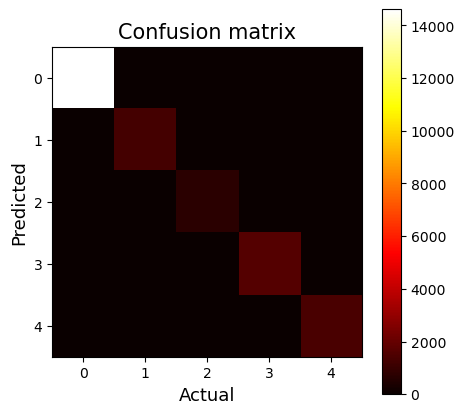


New checkpoint

train mode | time: 15:38:47
completed metrics calc
loss: 0.9191916045734301, accuracy: 0.9919392837910616, f1: 0.9825035674599593, precision: 0.9820207659131874, recall: 0.9866212818927667


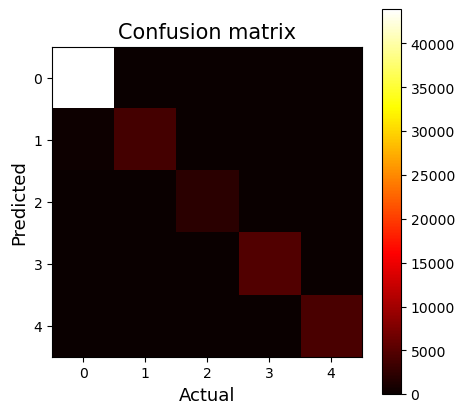

val mode | time: 15:42:24
completed metrics calc
loss: 0.9181099481953, accuracy: 0.997269417475729, f1: 0.9902488490536144, precision: 0.9881000636419601, recall: 0.9954036701144213


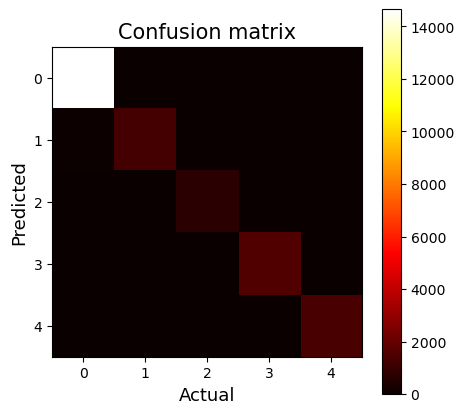


New checkpoint

train mode | time: 15:42:45
completed metrics calc
loss: 0.9157694591651633, accuracy: 0.9940932956381268, f1: 0.9867418354485776, precision: 0.9868830287767014, recall: 0.9895451918583876


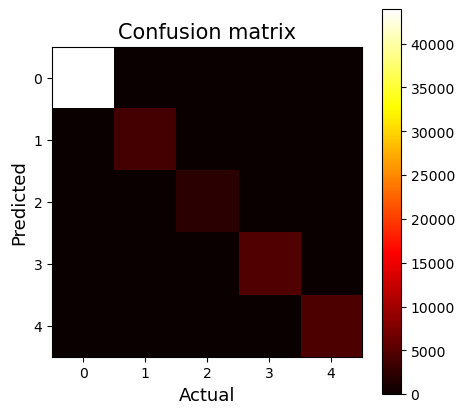

val mode | time: 15:46:23
completed metrics calc
loss: 0.917326591547253, accuracy: 0.9976739482200653, f1: 0.9908155871518535, precision: 0.9877258669845796, recall: 0.9968646998403285


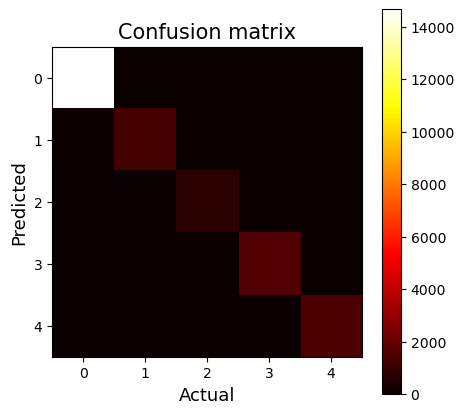


New checkpoint

train mode | time: 15:46:44
completed metrics calc
loss: 0.9132281355981102, accuracy: 0.9958602584814215, f1: 0.990421937762729, precision: 0.990536083088215, recall: 0.9923538866642275


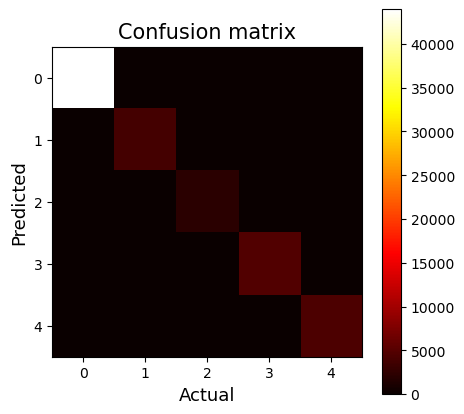

val mode | time: 15:50:21
completed metrics calc
loss: 0.915122195933629, accuracy: 0.9992920711974119, f1: 0.9940777774762459, precision: 0.9914772859215355, recall: 0.9992698528772832


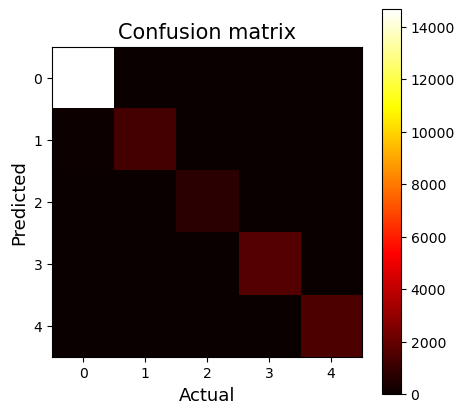


New checkpoint

train mode | time: 15:50:43
completed metrics calc
loss: 0.9113595220884715, accuracy: 0.9972233441033935, f1: 0.9927222984082891, precision: 0.9928547222217814, recall: 0.9942166901414462


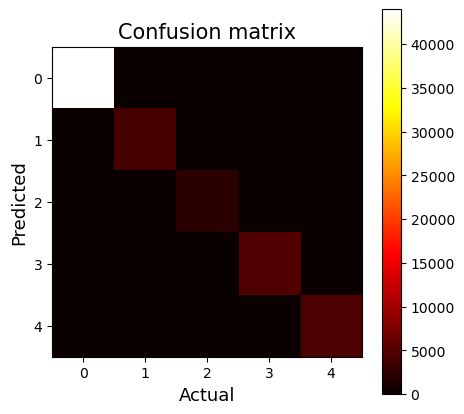

val mode | time: 15:54:19
completed metrics calc
loss: 0.9151512109538884, accuracy: 0.9995449029126221, f1: 0.9937394808281631, precision: 0.9932330815713875, recall: 0.9969214298449203


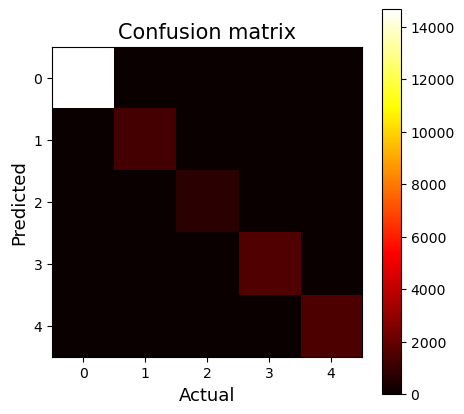

train mode | time: 15:54:41
completed metrics calc
loss: 0.9102921136361525, accuracy: 0.9982162089391491, f1: 0.994902284224146, precision: 0.9947419151194857, recall: 0.9962966916592301


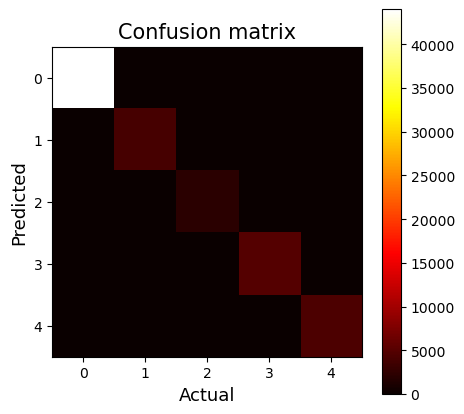

val mode | time: 15:58:16
completed metrics calc
loss: 0.9136734590368364, accuracy: 1.0007584951456314, f1: 0.996420851817016, precision: 0.9954896720880494, recall: 0.9993773974654009


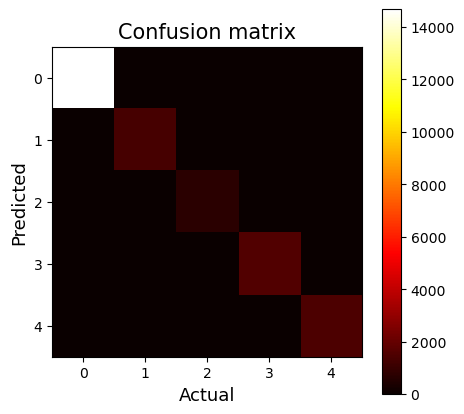


New checkpoint

train mode | time: 15:58:37
completed metrics calc
loss: 0.9093597948262302, accuracy: 0.9990239633817989, f1: 0.996251384765704, precision: 0.9962842272722537, recall: 0.9973536405829242


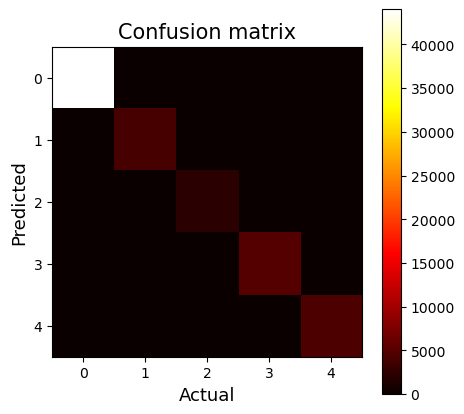

val mode | time: 16:02:17
completed metrics calc
loss: 0.9129538541858636, accuracy: 1.0014664239482203, f1: 0.9977889432593481, precision: 0.9968822041507058, recall: 1.0005372870506624


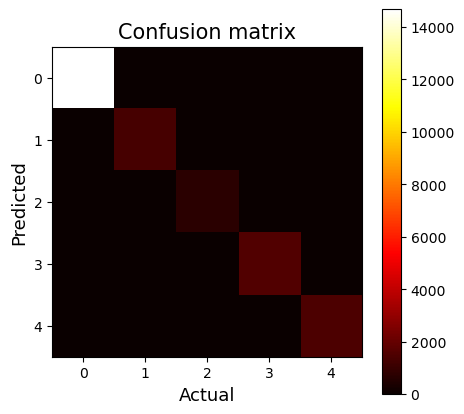

train mode | time: 16:02:39
completed metrics calc
loss: 0.9085642192783572, accuracy: 0.9996970920840068, f1: 0.9978942106279594, precision: 0.9974434659577414, recall: 0.9990053729347815


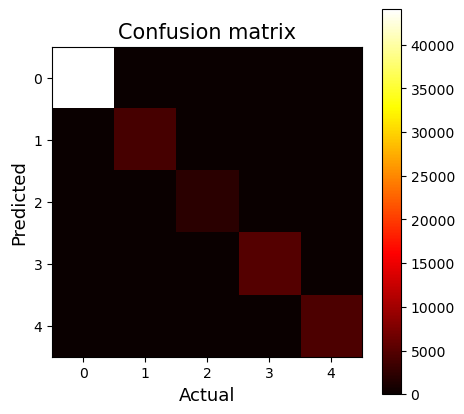

val mode | time: 16:06:18
completed metrics calc
loss: 0.912199161006409, accuracy: 1.0021237864077674, f1: 0.9990750789302204, precision: 0.999073740991146, recall: 1.000781715888369


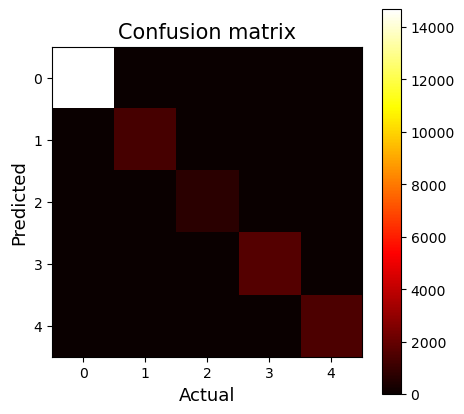

train mode | time: 16:06:39
completed metrics calc
loss: 0.9080444673536667, accuracy: 1.0001514539579968, f1: 0.9987082237932675, precision: 0.9983946239433826, recall: 0.9995700432785868


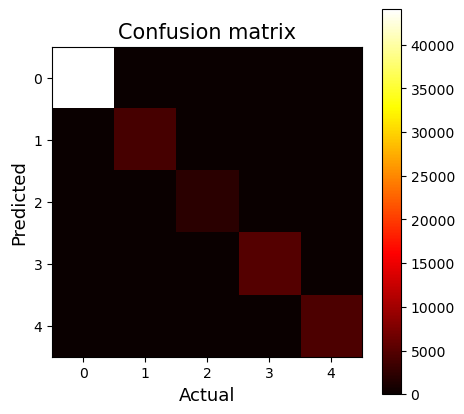

val mode | time: 16:10:18
completed metrics calc
loss: 0.9118903169354189, accuracy: 1.0024777508090619, f1: 0.9997422871651264, precision: 0.9996517969507143, recall: 1.0014610046069945


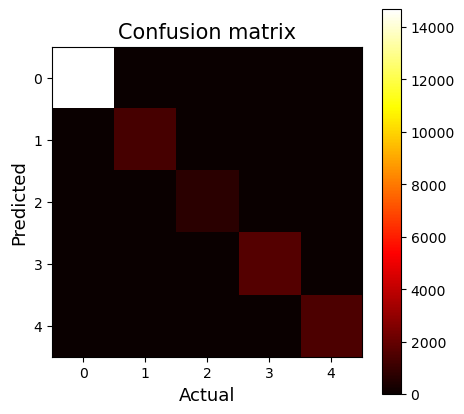

train mode | time: 16:10:39
completed metrics calc
loss: 0.9076562746275992, accuracy: 1.000538502961766, f1: 0.9995640000783812, precision: 0.9992319677149709, recall: 1.000280560426827


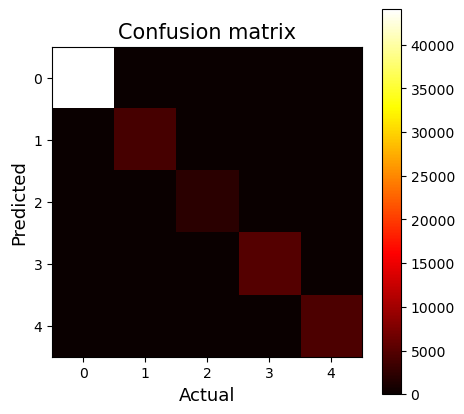

val mode | time: 16:14:18
completed metrics calc
loss: 0.9117978724461158, accuracy: 1.002477750809062, f1: 0.9996219992510607, precision: 0.9995750527041072, recall: 1.001310841194264


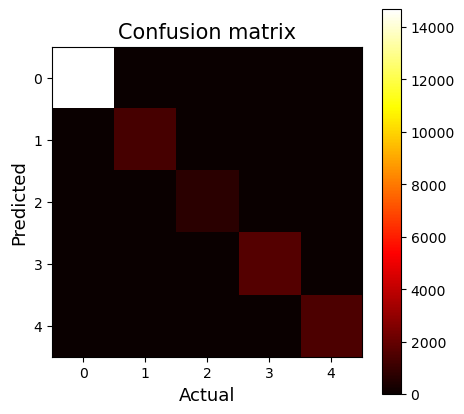

train mode | time: 16:14:55
completed metrics calc
loss: 0.9885900579091998, accuracy: 0.9227180936995157, f1: 0.8121936766072756, precision: 0.7942026523430608, recall: 0.8956616112252758


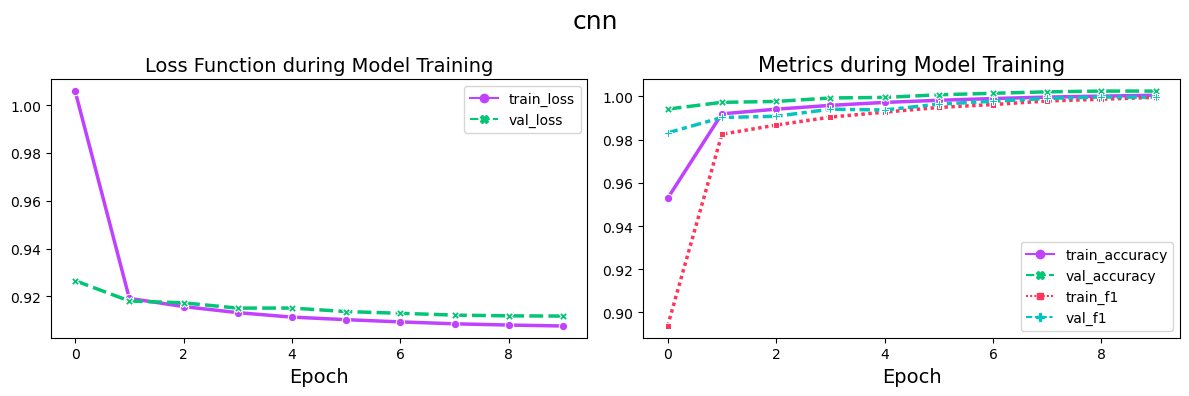

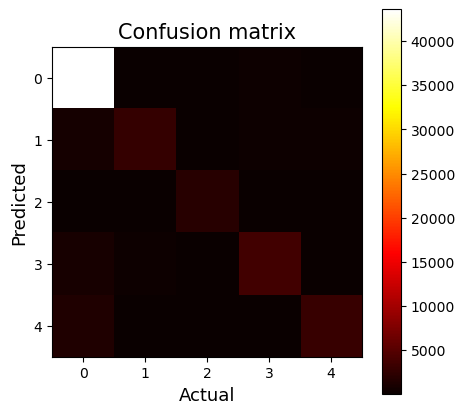

val mode | time: 16:16:47
completed metrics calc
loss: 0.9481699622950508, accuracy: 0.9661582606549278, f1: 0.9270693736669925, precision: 0.9125807065773404, recall: 0.9615731807556869


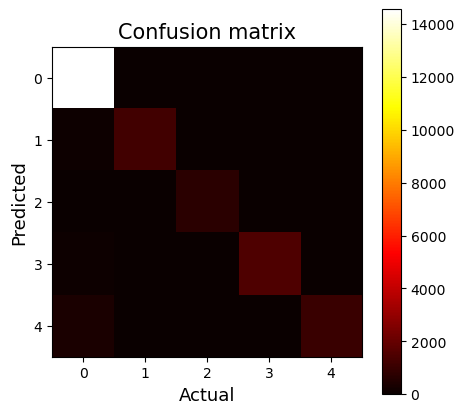


New checkpoint

train mode | time: 16:17:00
completed metrics calc
loss: 0.9426240002396419, accuracy: 0.9653809908454501, f1: 0.9264720775883127, precision: 0.9097286863759073, recall: 0.9614812257127991


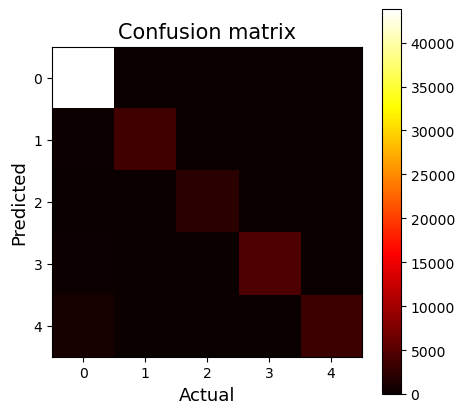

val mode | time: 16:18:56
completed metrics calc
loss: 0.941667968497693, accuracy: 0.97227678816302, f1: 0.9377915904595836, precision: 0.9259395406671189, recall: 0.9677911609479405


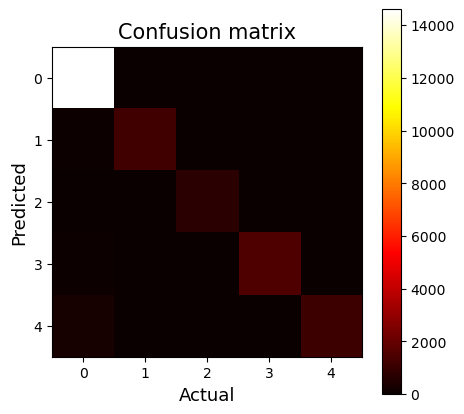

train mode | time: 16:19:09
completed metrics calc
loss: 0.9370698002505572, accuracy: 0.9708333333333341, f1: 0.9389307878936043, precision: 0.921960282221589, recall: 0.9723573069558274


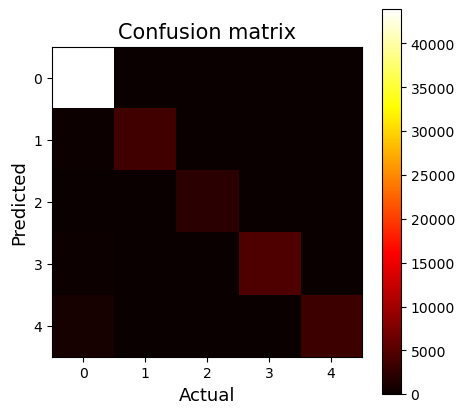

val mode | time: 16:21:07
completed metrics calc
loss: 0.9382617048268179, accuracy: 0.9757152994898798, f1: 0.9461003942738923, precision: 0.9299103128950503, recall: 0.9812760311064413


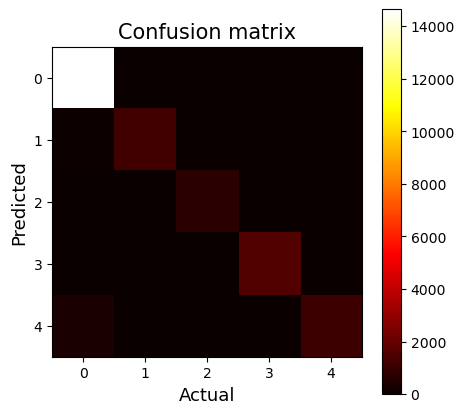


New checkpoint

train mode | time: 16:21:20
completed metrics calc
loss: 0.9326573422536711, accuracy: 0.9752793484114167, f1: 0.9451037862711344, precision: 0.9315598001540317, recall: 0.9743894635072738


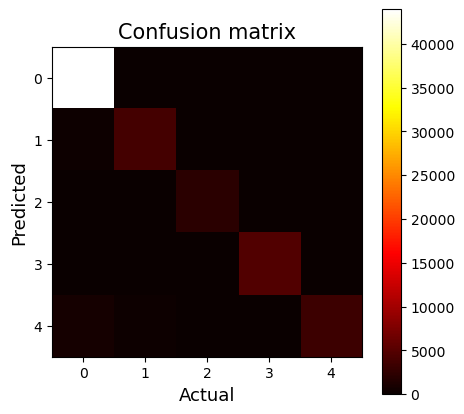

val mode | time: 16:23:16
completed metrics calc
loss: 0.9366720530014594, accuracy: 0.977535687839395, f1: 0.9511162330358763, precision: 0.9338120973504651, recall: 0.9855391267588021


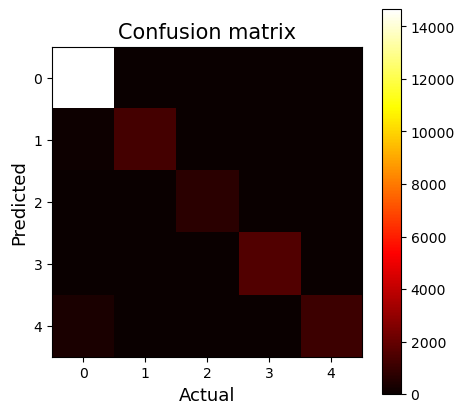

train mode | time: 16:23:29
completed metrics calc
loss: 0.9304209162807618, accuracy: 0.9775343295638126, f1: 0.9496403278503109, precision: 0.9375538634208815, recall: 0.9767243999197366


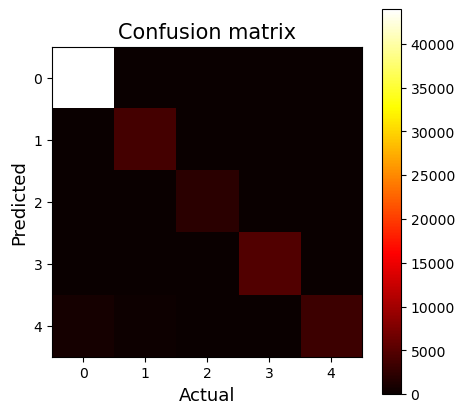

val mode | time: 16:25:25
completed metrics calc
loss: 0.9351148802099876, accuracy: 0.9788692680050465, f1: 0.9521136170253112, precision: 0.939029300709788, recall: 0.9815651127969168


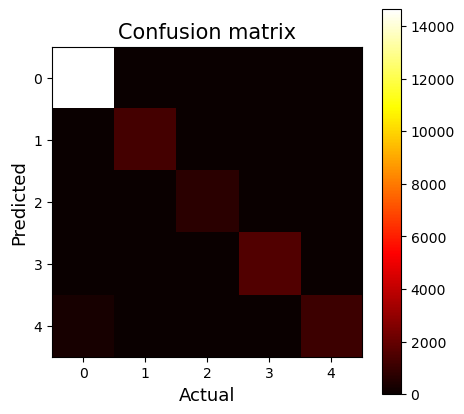

train mode | time: 16:25:38
completed metrics calc
loss: 0.9295232415391863, accuracy: 0.9783589122240175, f1: 0.9516344386028804, precision: 0.9390719915541984, recall: 0.9789862596453274


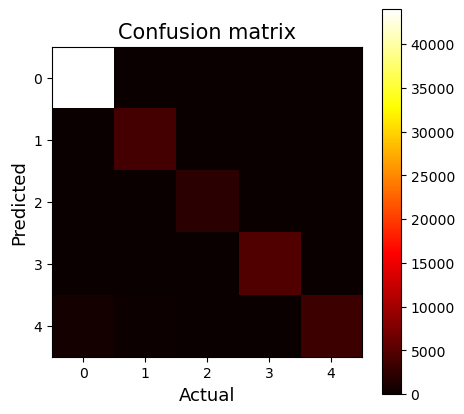

val mode | time: 16:27:34
completed metrics calc
loss: 0.9348625236923255, accuracy: 0.978951545444573, f1: 0.9466717583058881, precision: 0.9370940851501319, recall: 0.9757349582614016


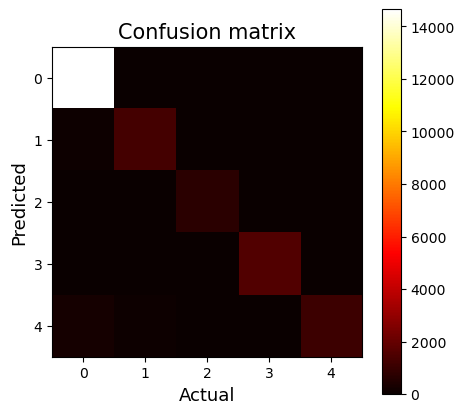


New checkpoint

train mode | time: 16:27:47
completed metrics calc
loss: 0.9280362373792682, accuracy: 0.9796378567582126, f1: 0.9506957674213126, precision: 0.941475091471635, recall: 0.975442073087624


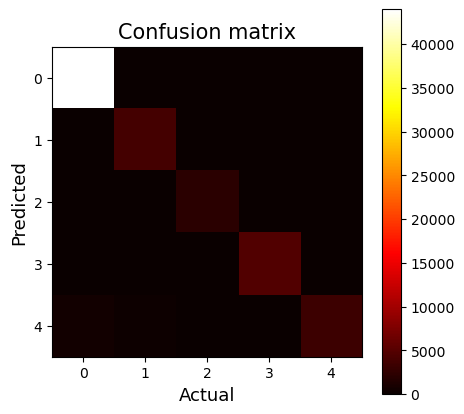

val mode | time: 16:29:42
completed metrics calc
loss: 0.9337082652791032, accuracy: 0.9800640049914983, f1: 0.9436592143739218, precision: 0.9406335603569064, recall: 0.9677922324693953


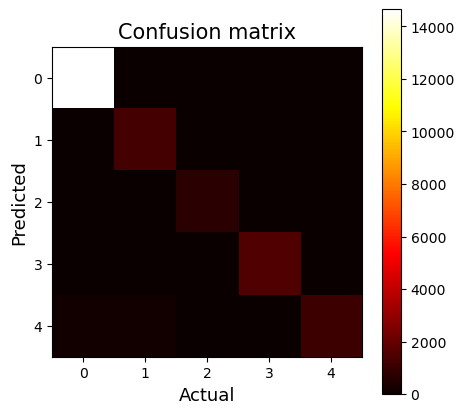

train mode | time: 16:29:55
completed metrics calc
loss: 0.9271772575108801, accuracy: 0.9805129240710837, f1: 0.9501616809620496, precision: 0.9430899282054377, recall: 0.9729032291378144


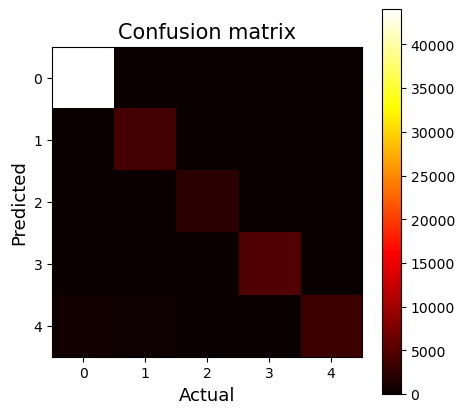

val mode | time: 16:31:48
completed metrics calc
loss: 0.9328470322692278, accuracy: 0.98107533185234, f1: 0.9499081865975101, precision: 0.9423784877970628, recall: 0.9763769766476891


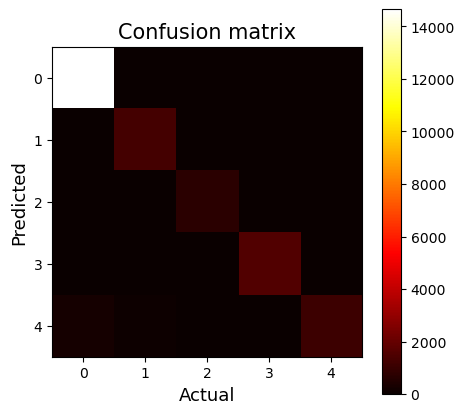


New checkpoint

train mode | time: 16:32:01
completed metrics calc
loss: 0.9265057395463614, accuracy: 0.9811860527732915, f1: 0.9513733848256829, precision: 0.9440806421853789, recall: 0.9740841730369264


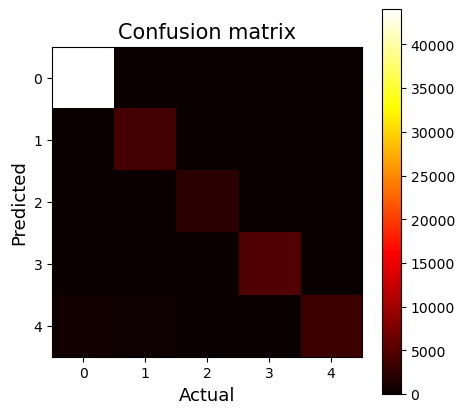

val mode | time: 16:33:56
completed metrics calc
loss: 0.9323968459101557, accuracy: 0.9814798625966764, f1: 0.950056953822698, precision: 0.943583850309647, recall: 0.9752331263894225


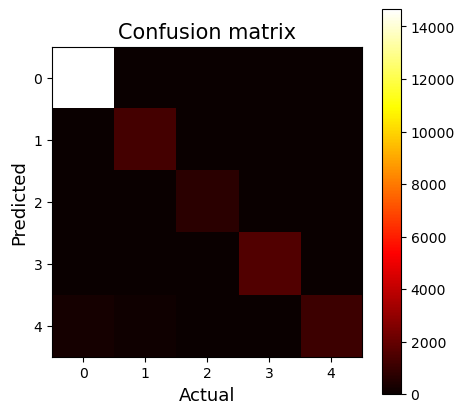

train mode | time: 16:34:10
completed metrics calc
loss: 0.9260522620165675, accuracy: 0.9816404146472812, f1: 0.952516569021774, precision: 0.9449676382608816, recall: 0.9753276697881975


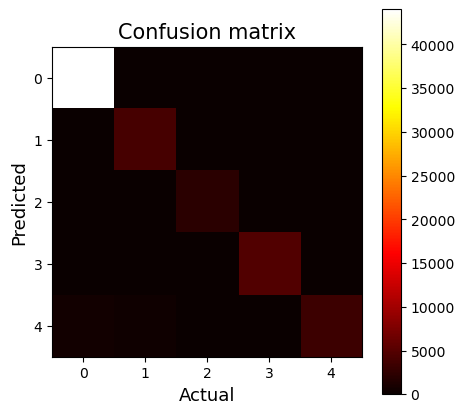

val mode | time: 16:36:06
completed metrics calc
loss: 0.9322726301197867, accuracy: 0.9814798625966763, f1: 0.947201396139939, precision: 0.9440691345342994, recall: 0.970163602614323


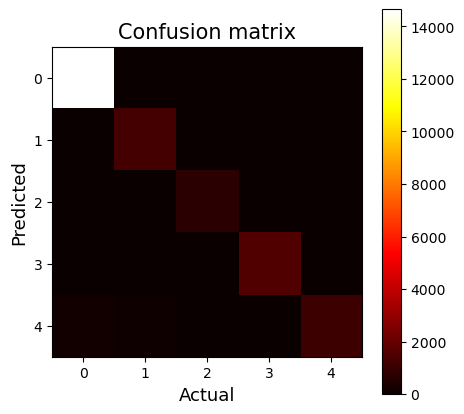

train mode | time: 16:36:34
completed metrics calc
loss: 1.1394991832326418, accuracy: 0.7877625201938613, f1: 0.3377065567975027, precision: 0.3829634192184027, recall: 0.7966296444847154


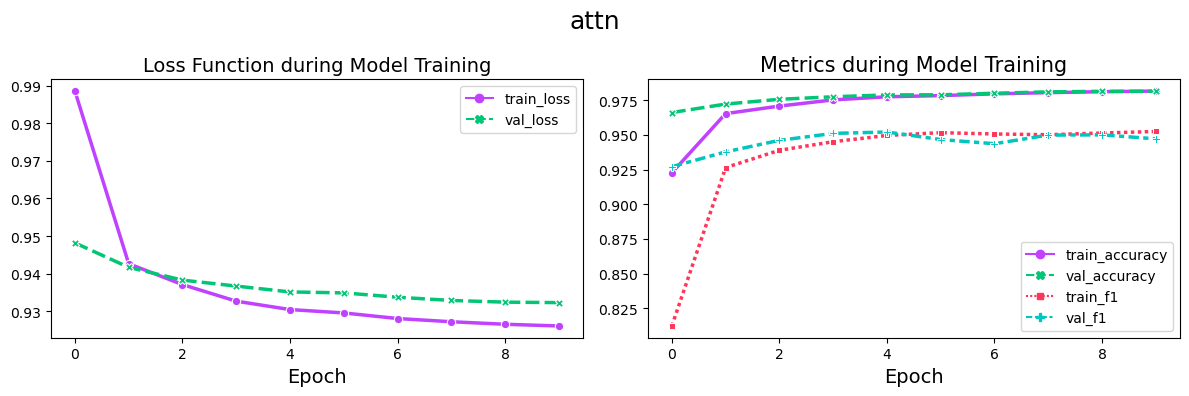

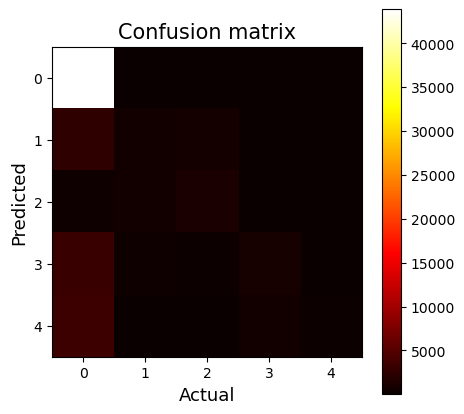

val mode | time: 16:38:45
completed metrics calc
loss: 1.0786980133033492, accuracy: 0.842573261203445, f1: 0.5651878740596258, precision: 0.5604520564942401, recall: 0.8484243309756418


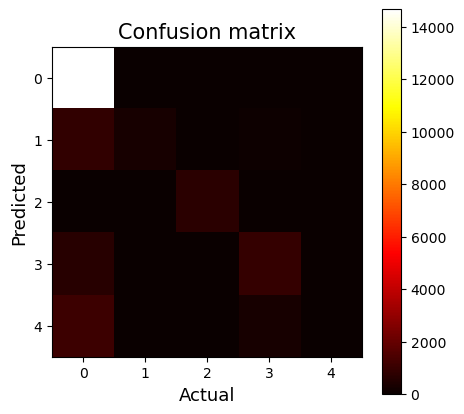


New checkpoint

train mode | time: 16:39:00
completed metrics calc
loss: 1.004144605411659, accuracy: 0.9119514001077003, f1: 0.7966056836200631, precision: 0.7666220542737315, recall: 0.8961206873671169


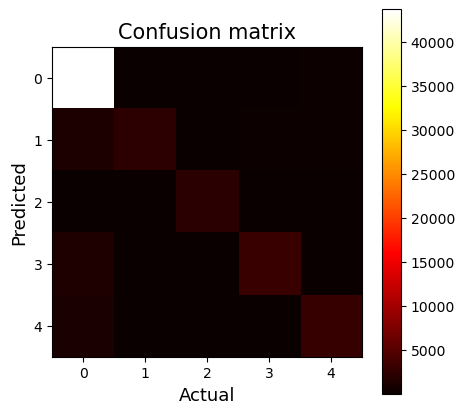

val mode | time: 16:41:10
completed metrics calc
loss: 0.9857576000458986, accuracy: 0.9347119946793925, f1: 0.8542085665437571, precision: 0.8190756092925737, recall: 0.9313146936637241


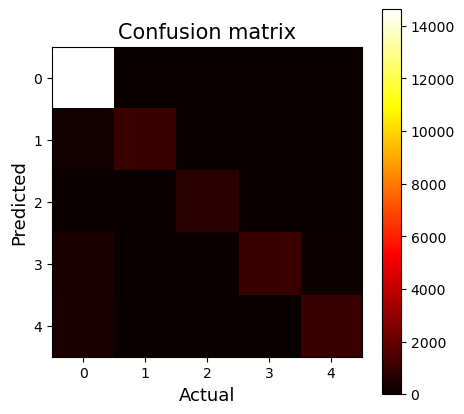


New checkpoint

train mode | time: 16:41:24
completed metrics calc
loss: 0.9711485942268988, accuracy: 0.9401420301561664, f1: 0.8695462623534073, precision: 0.8427542352901849, recall: 0.9310007213012224


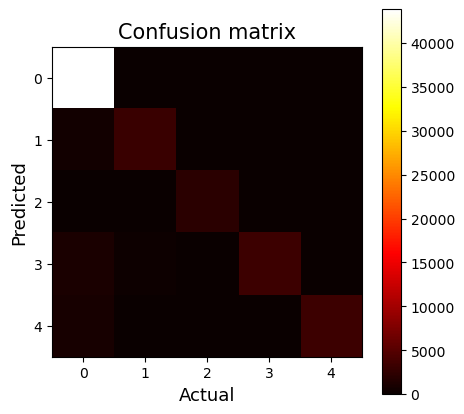

val mode | time: 16:43:36
completed metrics calc
loss: 0.9578438658737441, accuracy: 0.9595023586199334, f1: 0.9101387712311093, precision: 0.8913265084812083, recall: 0.956367896601281


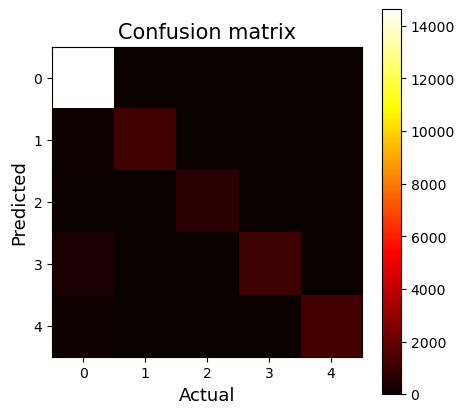


New checkpoint

train mode | time: 16:43:50
completed metrics calc
loss: 0.9491859638825757, accuracy: 0.9612109585352724, f1: 0.914189627810458, precision: 0.9043994575564105, recall: 0.9443028606690003


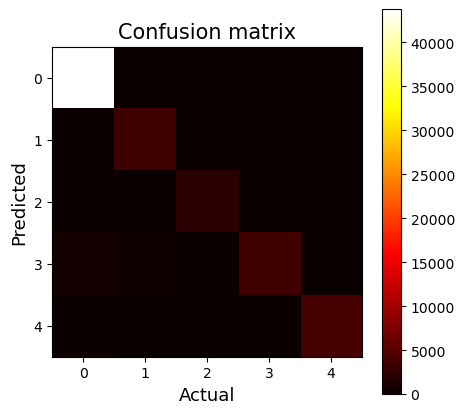

val mode | time: 16:46:01
completed metrics calc
loss: 0.9328650849536785, accuracy: 0.9846972533048107, f1: 0.9568308262547587, precision: 0.9549934518400967, recall: 0.970882748933723


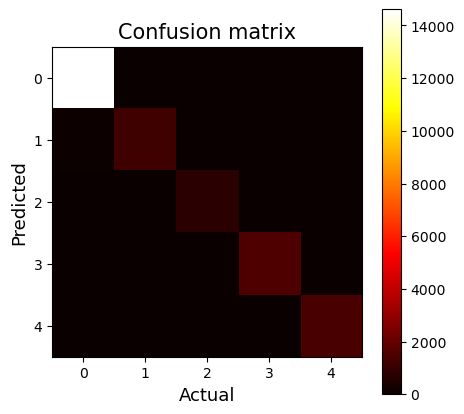


New checkpoint

train mode | time: 16:46:16
completed metrics calc
loss: 0.9236218967807505, accuracy: 0.9865037695207315, f1: 0.9670723500744518, precision: 0.9663378703988442, recall: 0.975573838573576


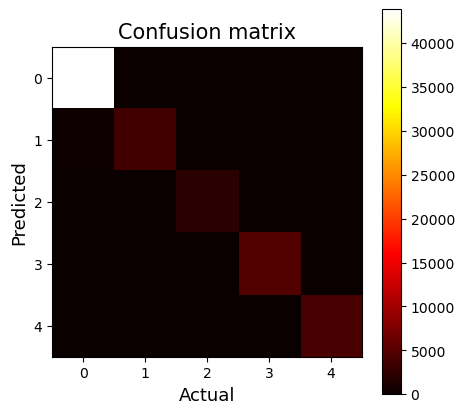

val mode | time: 16:48:28
completed metrics calc
loss: 0.9279391736660189, accuracy: 0.9879334992595035, f1: 0.9665402361334258, precision: 0.9626213317813015, recall: 0.9798575131510102


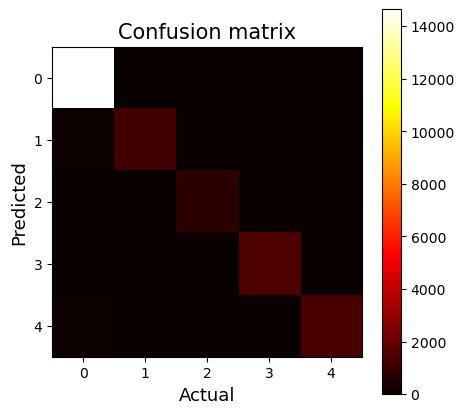

train mode | time: 16:48:42
completed metrics calc
loss: 0.9189945822386056, accuracy: 0.9903069466882062, f1: 0.9763009351414323, precision: 0.9741292577206161, recall: 0.9836212224927325


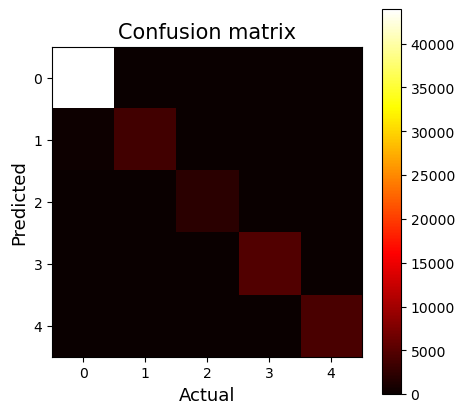

val mode | time: 16:50:55
completed metrics calc
loss: 0.9208588577011256, accuracy: 0.9941848705501621, f1: 0.9771056246505391, precision: 0.9807665097909559, recall: 0.9817486668281022


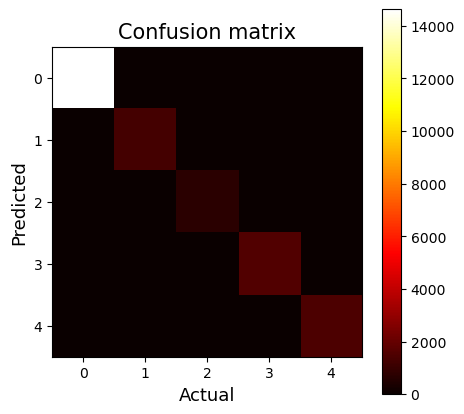


New checkpoint

train mode | time: 16:51:10
completed metrics calc
loss: 0.9174583341462932, accuracy: 0.9915354065697359, f1: 0.979316896861641, precision: 0.9773277742986185, recall: 0.985845891024183


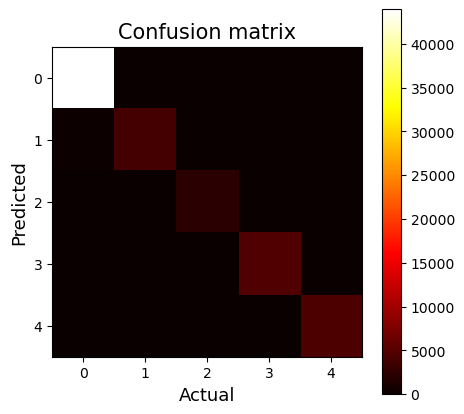

val mode | time: 16:53:24
completed metrics calc
loss: 0.9260656278110245, accuracy: 0.9887742718446606, f1: 0.9697007175509685, precision: 0.9639877691643683, recall: 0.9844835200691471


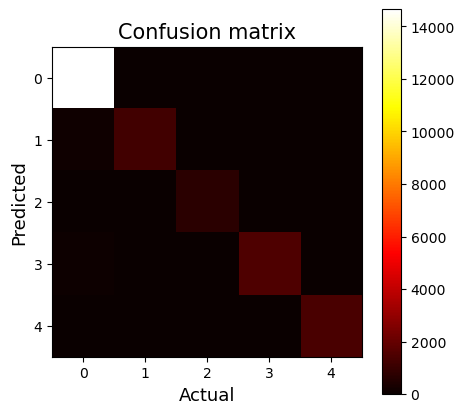


New checkpoint

train mode | time: 16:53:39
completed metrics calc
loss: 0.9153151067277726, accuracy: 0.9935379644588045, f1: 0.983037070552214, precision: 0.9814476883469925, recall: 0.9888496932497062


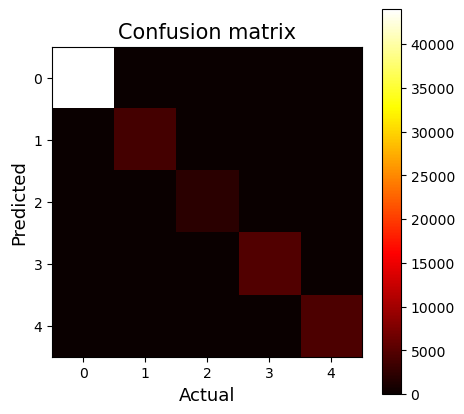

val mode | time: 16:55:54
completed metrics calc
loss: 0.919364337782258, accuracy: 0.9954173180297304, f1: 0.9814052518500738, precision: 0.9838520598645355, recall: 0.9851824378456674


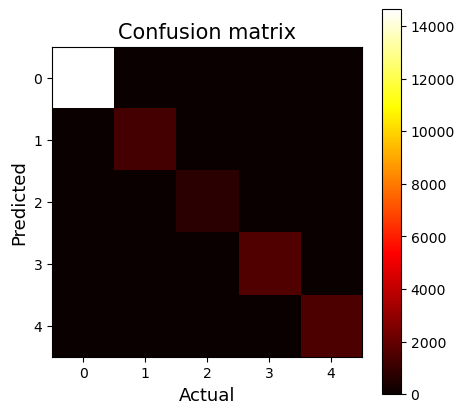

train mode | time: 16:56:09
completed metrics calc
loss: 0.9154733239352607, accuracy: 0.9934369951534732, f1: 0.9836722613026051, precision: 0.9832711625935348, recall: 0.9874981621208675


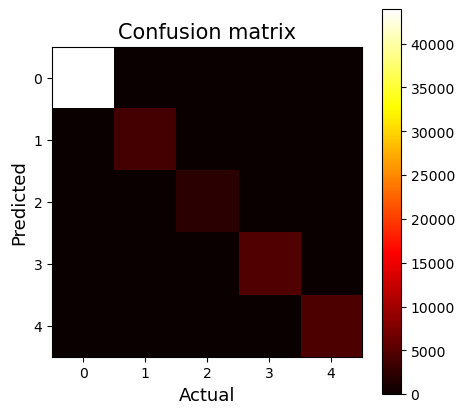

val mode | time: 16:58:25
completed metrics calc
loss: 0.9209134309615904, accuracy: 0.9940331715210362, f1: 0.9789796617769155, precision: 0.982325579262242, recall: 0.9833200428164627


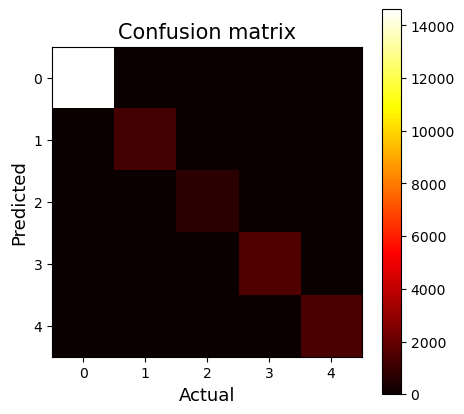


New checkpoint

train mode | time: 16:58:40
completed metrics calc
loss: 0.9143851900139225, accuracy: 0.9944298599892293, f1: 0.9862280684052992, precision: 0.9846478483704287, recall: 0.9907280081556185


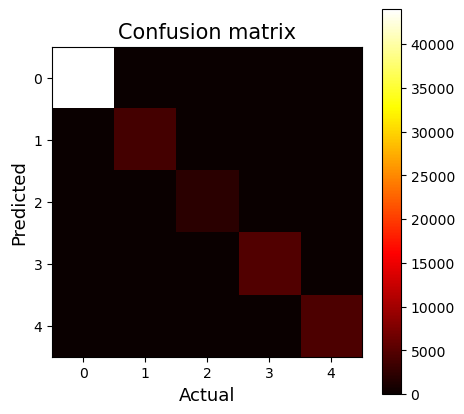

val mode | time: 17:00:55
completed metrics calc
loss: 0.918928920354658, accuracy: 0.9961569579288033, f1: 0.9833698288120907, precision: 0.9848057373162303, recall: 0.9886145623022617


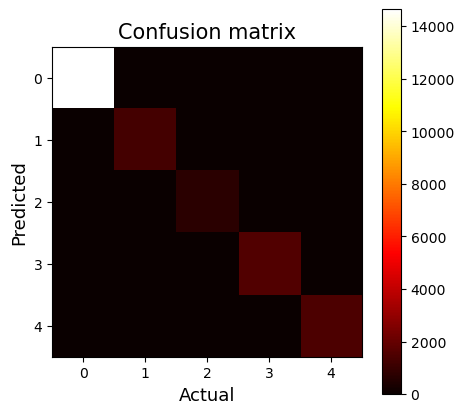

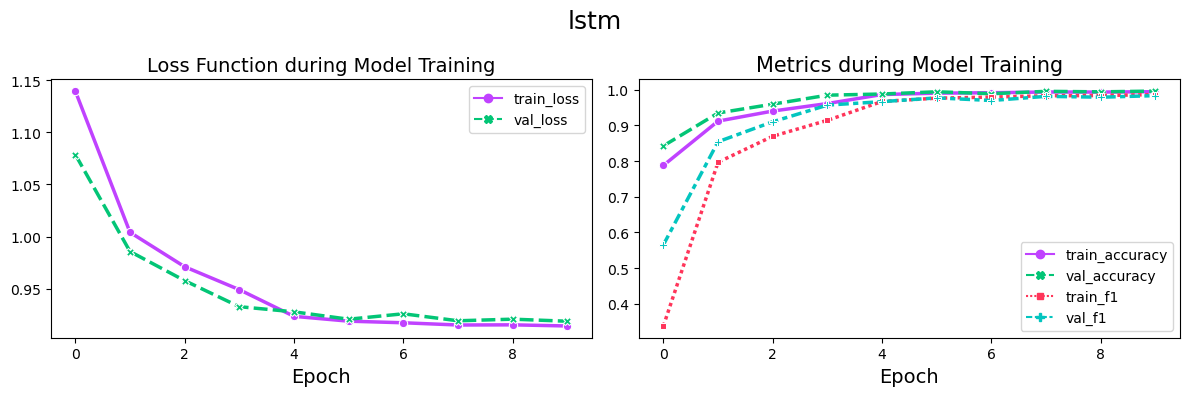

In [19]:
for model_nm, model in model_dict.items():
    n_model_logs_aggregator(model, model_nm)

In [20]:
# lstm_model = RNNModel(1, 64, 'lstm', True).to(config.device)
# lstm_model.load_state_dict(
#     torch.load(config.lstm_state_path,
#                map_location=config.device)
# );
# lstm_model.eval();
# logs = pd.read_csv(config.lstm_logs)

In [21]:
# colors = ['#C042FF', '#03C576FF', '#FF355A', '#03C5BF', '#96C503', '#C5035B']
# palettes = [sns.color_palette(colors, 2),
#             sns.color_palette(colors, 4), 
#             sns.color_palette(colors[:2]+colors[-2:] + colors[2:-2], 6)]
            
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# sns.lineplot(data=logs.iloc[:, :2], palette=palettes[0], markers=True, ax=ax[0], linewidth=2.5,)
# ax[0].set_title("Loss Function during Model Training", fontsize=14)
# ax[0].set_xlabel("Epoch", fontsize=14)

# sns.lineplot(data=logs.iloc[:, 2:6], palette=palettes[1], markers=True, ax=ax[1], linewidth=2.5, legend="full")
# ax[1].set_title("Metrics during Model Training", fontsize=15)
# ax[1].set_xlabel("Epoch", fontsize=14)

# plt.suptitle('CNN+LSTM Model', fontsize=18)

# plt.tight_layout()
# fig.savefig("lstm.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
# fig.savefig("lstm.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [22]:
# attn_model = RNNAttentionModel(1, 64, 'lstm', False).to(config.device)
# attn_model.load_state_dict(
#     torch.load(config.attn_state_path,
#                map_location=config.device)
# );
# attn_model.eval();
# logs = pd.read_csv(config.attn_logs)

In [23]:
# colors = ['#C042FF', '#03C576FF', '#FF355A', '#03C5BF', '#96C503', '#C5035B']
# palettes = [sns.color_palette(colors, 2),
#             sns.color_palette(colors, 4), 
#             sns.color_palette(colors[:2]+colors[-2:] + colors[2:-2], 6)]
            
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# sns.lineplot(data=logs.iloc[:, :2], palette=palettes[0], markers=True, ax=ax[0], linewidth=2.5,)
# ax[0].set_title("Loss Function during Model Training", fontsize=14)
# ax[0].set_xlabel("Epoch", fontsize=14)

# sns.lineplot(data=logs.iloc[:, 2:6], palette=palettes[1], markers=True, ax=ax[1], linewidth=2.5, legend="full")
# ax[1].set_title("Metrics during Model Training", fontsize=15)
# ax[1].set_xlabel("Epoch", fontsize=14)

# plt.suptitle('CNN+LSTM+Attention Model', fontsize=18)

# plt.tight_layout()
# fig.savefig("attn.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
# fig.savefig("attn.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [24]:
## Testing

In [25]:
test_dataloader = get_dataloader(train_csv_path=config.ecg_csv_path, phase='test', batch_size =96)

In [26]:
def make_test_stage(dataloader, model, probs=False):
    cls_predictions = []
    cls_ground_truths = []

    for i, (data, cls_target) in enumerate(dataloader):
        with torch.no_grad():

            data = data.to(config.device)
            cls_target = cls_target.cpu()
            cls_prediction = model(data)
            
            if not probs:
                cls_prediction = torch.argmax(cls_prediction, dim=1)
    
            cls_predictions.append(cls_prediction.detach().cpu())
            cls_ground_truths.append(cls_target)

    predictions_cls = torch.cat(cls_predictions).numpy()
    ground_truths_cls = torch.cat(cls_ground_truths).numpy()
    return predictions_cls, ground_truths_cls

In [27]:
models = [m1, m3, m2]


In [28]:
y_pred, y_true = make_test_stage(test_dataloader, models[0])
y_pred.shape, y_true.shape

((19835,), (19835,))

In [29]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

<Figure size 1400x600 with 0 Axes>

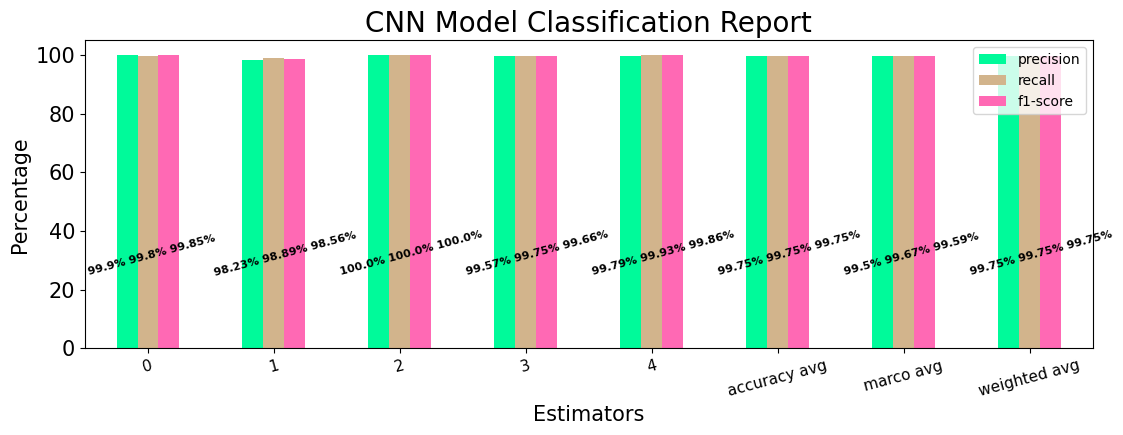

In [30]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)

fig = plt.figure(figsize=(14,6))

ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):
    
    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("cnn_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("cnn_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

In [31]:
##cnn + lstm
y_pred, y_true = make_test_stage(test_dataloader, models[1])
y_pred.shape, y_true.shape

((19835,), (19835,))

In [32]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

<Figure size 1400x600 with 0 Axes>

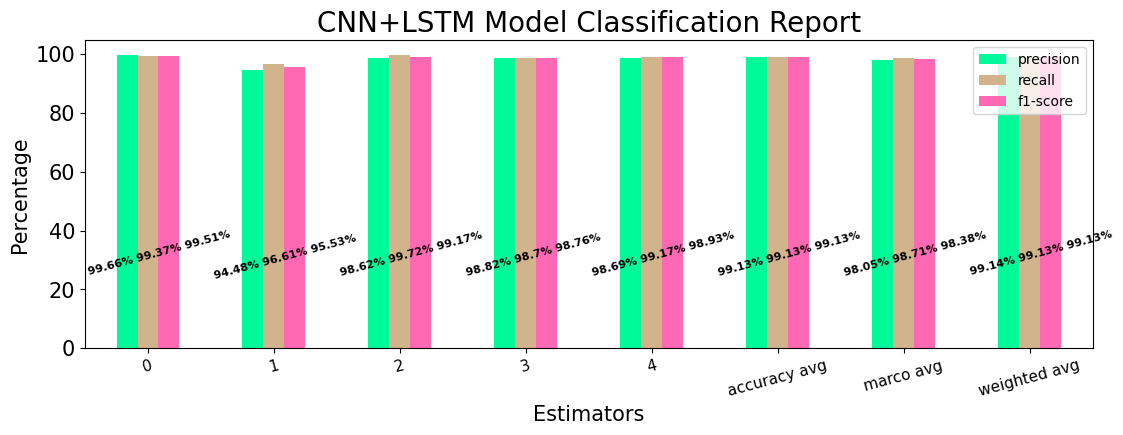

In [33]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)
fig = plt.figure(figsize=(14,6))

ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN+LSTM Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):
    
    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("lstm_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("lstm_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

In [34]:
## cnn + lstm +attn
y_pred, y_true = make_test_stage(test_dataloader, models[2])
y_pred.shape, y_true.shape

((19835,), (19835,))

In [35]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

<Figure size 1400x600 with 0 Axes>

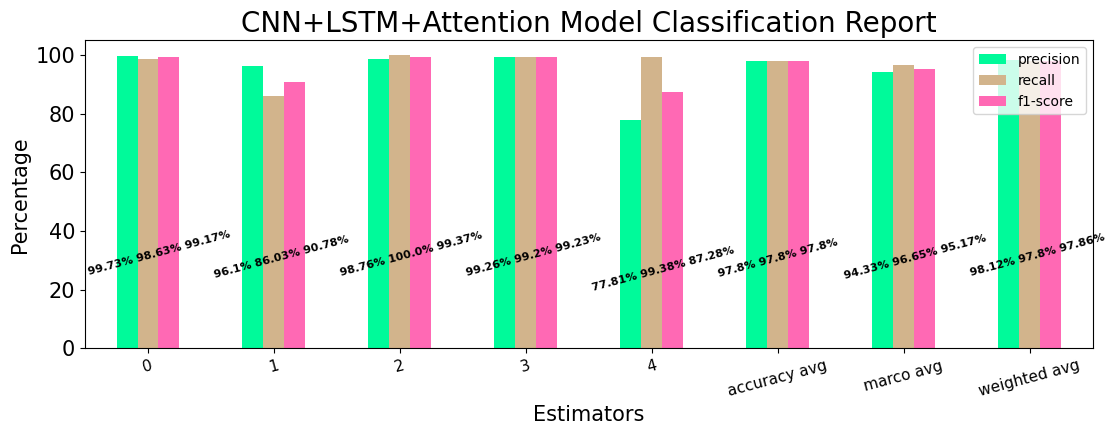

In [36]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)

fig = plt.figure(figsize=(14,6))
ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN+LSTM+Attention Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):
    
    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("attn_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("attn_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

In [37]:
## Ensemble
y_pred = np.zeros((y_pred.shape[0], 5), dtype=np.float32)
for i, model in enumerate(models, 1):
    y_pred_, y_true = make_test_stage(test_dataloader, model, True)
    y_pred += y_pred_
y_pred /= i
y_pred = np.argmax(y_pred, axis=1)

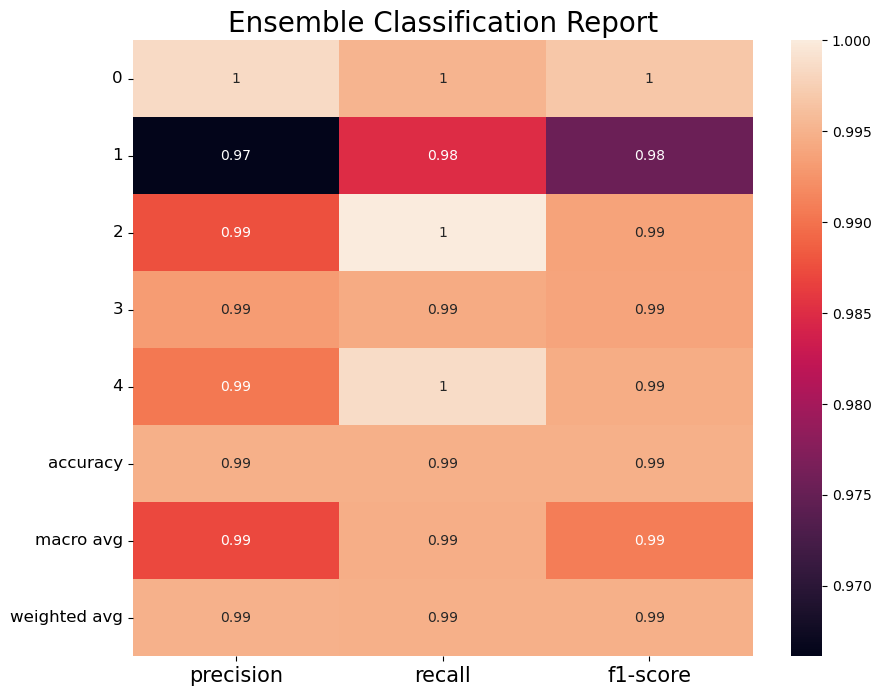

In [38]:
clf_report = classification_report(y_pred, 
                                   y_true,
                                   labels=[0,1,2,3,4],
                                   target_names=list(id_to_label.values()),#['N', 'S', 'V', 'F', 'Q'],
                                   output_dict=True)


plt.figure(figsize=(10, 8))
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12, rotation=0)
plt.title("Ensemble Classification Report", fontsize=20)
plt.savefig(f"ensemble result.svg",format="svg",bbox_inches='tight', pad_inches=0.2)
plt.savefig(f"ensemble result.png", format="png",bbox_inches='tight', pad_inches=0.2)

In [39]:
clf_report

{0: {'precision': 0.9984340958605664,
  'recall': 0.9951143380606636,
  'f1-score': 0.9967714528462192,
  'support': 14737},
 1: {'precision': 0.9661266568483063,
  'recall': 0.984984984984985,
  'f1-score': 0.9754646840148699,
  'support': 1332},
 2: {'precision': 0.9875690607734806,
  'recall': 1.0,
  'f1-score': 0.9937456567060459,
  'support': 715},
 3: {'precision': 0.993184634448575,
  'recall': 0.9944168734491315,
  'f1-score': 0.9938003719776813,
  'support': 1612},
 4: {'precision': 0.9903514817367333,
  'recall': 0.9986101459346769,
  'f1-score': 0.9944636678200692,
  'support': 1439},
 'accuracy': 0.9948071590622637,
 'macro avg': {'precision': 0.9871331859335323,
  'recall': 0.9946252684858914,
  'f1-score': 0.9908491666729772,
  'support': 19835},
 'weighted avg': {'precision': 0.994859857273628,
  'recall': 0.9948071590622637,
  'f1-score': 0.9948226580221057,
  'support': 19835}}